In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Optional
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import Ridge

In [203]:
in_dir = Path("data/processed/02")
folds = {}
for i in range(1, 3):
    print(f"Reading fold {i}:")
    folds[f"fold_{i}"] = {
        "X_train": pd.read_csv(f'{in_dir}/fold_{i}_X_train.csv'),
        "X_test": pd.read_csv(f'{in_dir}/fold_{i}_X_test.csv'),
        "y_train": pd.read_csv(f'{in_dir}/fold_{i}_y_train.csv').squeeze(),
        "y_test": pd.read_csv(f'{in_dir}/fold_{i}_y_test.csv').squeeze()
    }

X_train = folds["fold_1"]["X_train"];
y_train = folds["fold_1"]["y_train"];

print("Ready for Feature Classification:")
print(f"  Training features: {X_train.shape}")
print(f"  Features to classify: {len(X_train.columns)}")
print(f"  Data integrity verified: ✅")

Reading fold 1:
Reading fold 2:
Ready for Feature Classification:
  Training features: (8495, 18)
  Features to classify: 18
  Data integrity verified: ✅


In [204]:
def explore_dataset(df, name="Dataset"):
    """
    Print basic information and statistics about a dataset (DataFrame).

    Parameters
    ----------
    df : pd.DataFrame
        The dataset to explore.
    name : str, optional
        Name of the dataset (default: "Dataset").
    """
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)  # (rows, columns)
    print("Number of features:", df.shape[1])
    print("Number of samples:", df.shape[0])

    print("\n--- First 5 rows ---")
    print(df.head())

    print("\n--- Info ---")
    print(df.info())

    print("\n--- Statistics (numerical columns) ---")
    print(df.describe())

In [205]:
explore_dataset(X_train, name="Fold 1 X_train")


=== Fold 1 X_train ===
Shape: (8495, 18)
Number of features: 18
Number of samples: 8495

--- First 5 rows ---
   num__temp_C  num__dewpoint_C  num__slp_hPa  num__wind_dir_deg  \
0     1.118294         1.851607     -0.126166          -1.077484   
1     1.248428         0.584922     -0.725202          -0.211985   
2     1.161672         0.571154     -0.658642          -0.115819   
3     1.064071         0.653764     -0.671954          -0.500485   
4     1.042382         0.681301     -0.711890          -0.404318   

   num__precip_mm  cat__sky_cover_0  cat__sky_cover_0 -  cat__sky_cover_1  \
0        0.353852               0.0                 0.0               0.0   
1        0.353852               0.0                 1.0               0.0   
2        0.353852               0.0                 1.0               0.0   
3        0.353852               0.0                 1.0               0.0   
4        0.353852               0.0                 1.0               0.0   

   cat__sky_cover

In [206]:
def quality_report(df, name="Dataset"):
    """
    Print a quick quality report: missing values, data types, duplicates.
    
    Parameters
    ----------
    df : pd.DataFrame
        The dataset to check.
    name : str, optional
        Name of the dataset (default: "Dataset").
    """
    print(f"\n=== Quality Report: {name} ===")
    
    # Missing values
    missing_data = df.isnull().sum()
    missing = missing_data[missing_data > 0]
    if not missing.empty:
        print("\nMissing values per column:")
        print(missing)
    else:
        print("\nNo missing values detected.")
    
    # Data types
    print("\nData types:")
    print(df.dtypes)
    
    # Duplicate rows
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate rows: {duplicates}")

In [207]:
quality_report(X_train, name="Fold 1 X_train")


=== Quality Report: Fold 1 X_train ===

No missing values detected.

Data types:
num__temp_C           float64
num__dewpoint_C       float64
num__slp_hPa          float64
num__wind_dir_deg     float64
num__precip_mm        float64
cat__sky_cover_0      float64
cat__sky_cover_0 -    float64
cat__sky_cover_1      float64
cat__sky_cover_1 -    float64
cat__sky_cover_5      float64
cat__sky_cover_5 -    float64
cat__sky_cover_6      float64
cat__sky_cover_6 -    float64
cat__sky_cover_7 -    float64
dt__dt__hour          float64
dt__dt__dow           float64
dt__dt__month         float64
dt__dt__is_weekend    float64
dtype: object

Duplicate rows: 2


In [208]:
# Basic target statistics
print("Target Variable Analysis:")
print(f"Mean: {y_train.mean()}")
print(f"Median: {y_train.median()}")
print(f"Standard Deviation: {y_train.std()}")
print(f"Minimum: {y_train.min()}")
print(f"Maximum: {y_train.max()}")

# Check for missing values in target
print(f"Missing values: {y_train.isnull().sum()}")

Target Variable Analysis:
Mean: 41.282028585796354
Median: 36.55599346
Standard Deviation: 36.122103860994386
Minimum: 0.97232599
Maximum: 2217.67646288
Missing values: 0


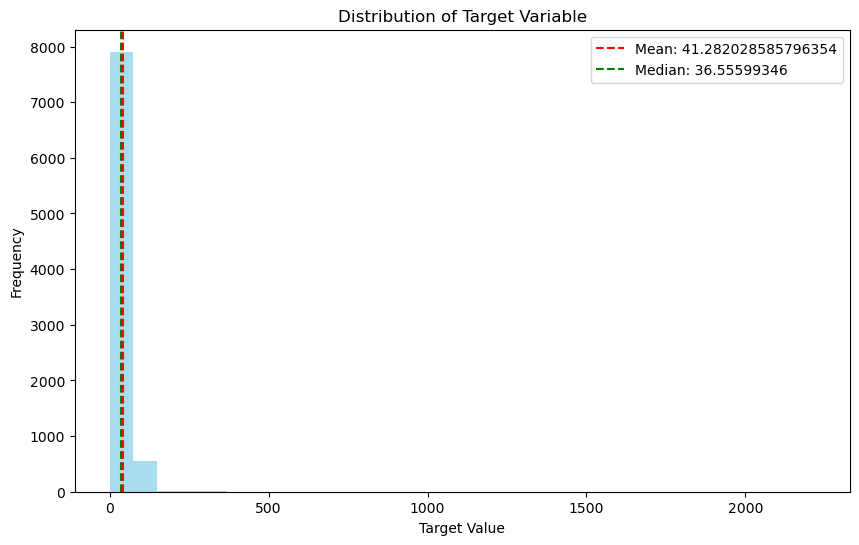

In [209]:
# Create a simple histogram
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=30, alpha=0.7, color='skyblue')
plt.axvline(y_train.mean(), color='red', linestyle='--', label=f'Mean: {y_train.mean()}')
plt.axvline(y_train.median(), color='green', linestyle='--', label=f'Median: {y_train.median()}')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.legend()
plt.show()

count    8495.00
mean       41.28
std        36.12
min         0.97
25%        25.52
50%        36.56
75%        50.64
max      2217.68
Name: target, dtype: float64


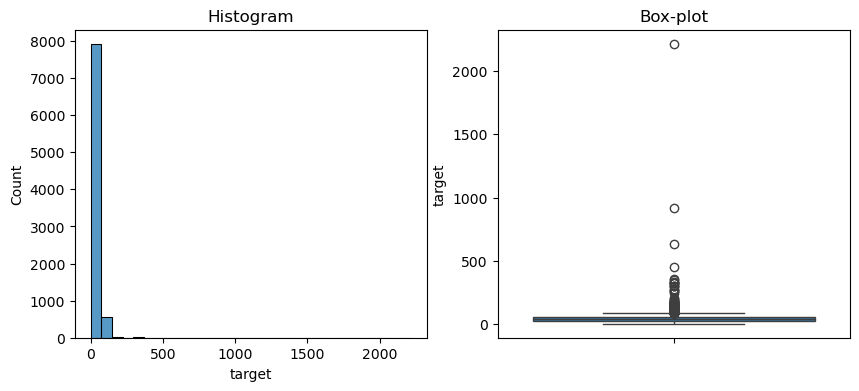

In [210]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.histplot(y_train, ax=ax[0], bins=30); ax[0].set_title("Histogram")
sns.boxplot(y_train, ax=ax[1]);            ax[1].set_title("Box-plot")
print(y_train.describe().round(2))

Numeric stats:
                     mean   std   min   max
num__temp_C         0.00  1.00 -3.00  2.57
num__dewpoint_C     0.00  1.00 -3.39  2.35
num__slp_hPa        0.00  1.00 -2.87  3.03
num__wind_dir_deg  -0.00  1.00 -1.85  1.52
num__precip_mm     -0.00  1.00 -2.82  1.26
cat__sky_cover_0    0.78  0.41  0.00  1.00
cat__sky_cover_0 -  0.17  0.38  0.00  1.00
cat__sky_cover_1    0.01  0.09  0.00  1.00
cat__sky_cover_1 -  0.01  0.07  0.00  1.00
cat__sky_cover_5    0.02  0.14  0.00  1.00
cat__sky_cover_5 -  0.01  0.08  0.00  1.00
cat__sky_cover_6    0.01  0.07  0.00  1.00
cat__sky_cover_6 -  0.00  0.06  0.00  1.00
cat__sky_cover_7 -  0.00  0.01  0.00  1.00
dt__dt__hour       -0.00  1.00 -1.61  1.66
dt__dt__dow        -0.00  1.00 -1.50  1.49
dt__dt__month      -0.00  1.00 -1.94  1.42
dt__dt__is_weekend -0.00  1.00 -0.64  1.57


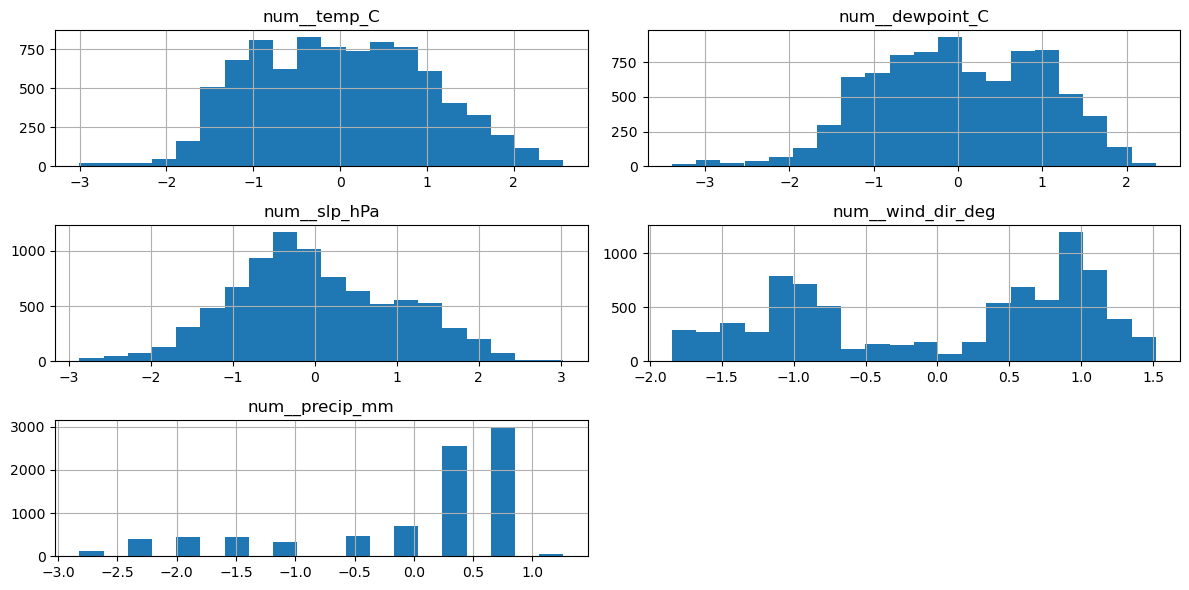

In [211]:
num_cols = X_train.select_dtypes('number').columns
print("Numeric stats:\n", X_train[num_cols].describe().T[['mean','std','min','max']].round(2))
# Plot first 5 histograms*
X_train[num_cols[:5]].hist(bins=20, figsize=(12,6))
plt.tight_layout()
plt.show()

Top correlations:
 dt__dt__hour          0.212
num__dewpoint_C      -0.152
num__slp_hPa          0.144
num__temp_C          -0.138
dt__dt__is_weekend   -0.114
dt__dt__dow          -0.077
num__wind_dir_deg    -0.065
cat__sky_cover_0     -0.059
cat__sky_cover_1      0.056
dt__dt__month        -0.052
cat__sky_cover_5      0.028
cat__sky_cover_0 -    0.028
cat__sky_cover_1 -    0.026
cat__sky_cover_5 -    0.022
cat__sky_cover_6 -    0.015
cat__sky_cover_6      0.011
num__precip_mm       -0.009
cat__sky_cover_7 -   -0.007
dtype: float64


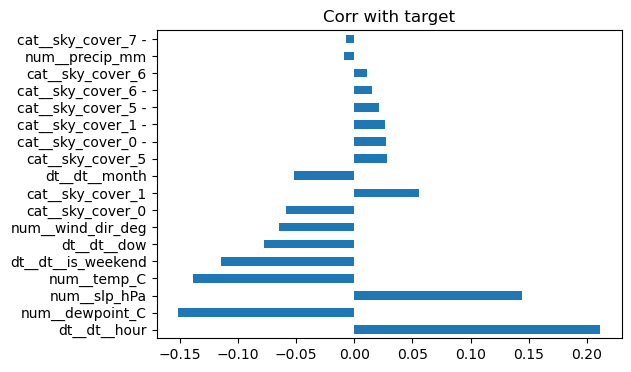

In [212]:
corrs = X_train[num_cols].corrwith(y_train).sort_values(key=abs, ascending=False)
print("Top correlations:\n", corrs.round(3))
corrs.plot.barh(figsize=(6,4)); plt.title("Corr with target"); plt.show()

In [213]:
def iqr_outliers(s):
    q1,q3=s.quantile([.25,.75]); iqr=q3-q1
    return s[(s<q1-1.5*iqr)|(s>q3+1.5*iqr)]
for col in num_cols[:]:
    outs = iqr_outliers(X_train[col])
    print(f"{col}: {len(outs)} outliers ({len(outs)/len(X_train)*100:.1f}%)")

num__temp_C: 0 outliers (0.0%)
num__dewpoint_C: 18 outliers (0.2%)
num__slp_hPa: 19 outliers (0.2%)
num__wind_dir_deg: 0 outliers (0.0%)
num__precip_mm: 112 outliers (1.3%)
cat__sky_cover_0: 1867 outliers (22.0%)
cat__sky_cover_0 -: 1468 outliers (17.3%)
cat__sky_cover_1: 63 outliers (0.7%)
cat__sky_cover_1 -: 45 outliers (0.5%)
cat__sky_cover_5: 158 outliers (1.9%)
cat__sky_cover_5 -: 57 outliers (0.7%)
cat__sky_cover_6: 44 outliers (0.5%)
cat__sky_cover_6 -: 31 outliers (0.4%)
cat__sky_cover_7 -: 1 outliers (0.0%)
dt__dt__hour: 0 outliers (0.0%)
dt__dt__dow: 0 outliers (0.0%)
dt__dt__month: 0 outliers (0.0%)
dt__dt__is_weekend: 0 outliers (0.0%)


In [214]:
corr_mat = X_train[num_cols].corr().abs()
high_corr = np.where((corr_mat>0.8)&(corr_mat<1.0))
pairs = [(num_cols[i],num_cols[j],corr_mat.iat[i,j]) 
         for i,j in zip(*high_corr) if i<j]
print("High-corr pairs:", pairs[:5])

High-corr pairs: [('num__temp_C', 'num__dewpoint_C', np.float64(0.8414268025734989)), ('cat__sky_cover_0', 'cat__sky_cover_0 -', np.float64(0.8611863586874918))]


In [215]:
print("🚀 EDA SNAPSHOT")
print(f"Target skew: {y_train.skew():.2f}")
print("Strongest predictor:", corrs.index[0], corrs.max().round(3))
miss = (X_train.isnull().mean()*100).sort_values(ascending=False).head(3)
print("Top missing cols:\n", miss.round(1))
print("High-corr pairs:", pairs[:3])

🚀 EDA SNAPSHOT
Target skew: 29.12
Strongest predictor: dt__dt__hour 0.212
Top missing cols:
 num__temp_C        0.0
num__dewpoint_C    0.0
dt__dt__month      0.0
dtype: float64
High-corr pairs: [('num__temp_C', 'num__dewpoint_C', np.float64(0.8414268025734989)), ('cat__sky_cover_0', 'cat__sky_cover_0 -', np.float64(0.8611863586874918))]


In [216]:
# ---------- Low correlation (feature ↔ target) ----------
class CorrelationWithTargetFilter(BaseEstimator, TransformerMixin):
    """
    Keep features whose absolute Pearson correlation with y is >= threshold.
    Assumes X is numeric.
    """
    def __init__(self, threshold: float = 0.1):
        self.threshold = threshold

    def fit(self, X, y=None):
        if y is None:
            raise ValueError("y is required to compute correlation with target.")
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        y_s = pd.Series(y).reset_index(drop=True)
        if len(X_df) != len(y_s):
            raise ValueError("X and y length mismatch.")
        cors = X_df.apply(lambda col: pd.Series(col).corr(y_s), axis=0)
        self.correlations_ = cors.values
        self.support_mask_ = cors.abs().fillna(0.0).values >= self.threshold
        return self

    def transform(self, X):
        check_is_fitted(self, "support_mask_")
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        return X_df.loc[:, self.support_mask_].to_numpy()

    def get_support(self) -> np.ndarray:
        check_is_fitted(self, "support_mask_")
        return self.support_mask_

In [217]:
# ---------- Multicollinearity filter (inter-feature correlation) ----------
class MulticollinearityFilter(BaseEstimator, TransformerMixin):
    """
    Drop features that are highly correlated with any already-kept feature.
    Greedy left-to-right; logs kept/dropped.
    """
    def __init__(self, threshold: float = 0.8, name: str = "multicol"):
        self.threshold = threshold
        self.name = name

    def fit(self, X, y=None):
        Xdf = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        cols = np.array(Xdf.columns)
        corr = Xdf.corr(numeric_only=True).abs().fillna(0.0).to_numpy()

        keep = np.ones(len(cols), dtype=bool)
        for i in range(len(cols)):
            if keep[i]:
                too_high = corr[i, (i+1):] >= self.threshold
                idx = np.where(too_high)[0] + (i + 1)
                keep[idx] = False

        self.support_mask_ = keep
        self.feature_names_in_ = cols
        self.dropped_ = cols[~keep].tolist()
        self.kept_ = cols[keep].tolist()

        print(f"[{self.name}] threshold={self.threshold} | kept={len(self.kept_)} dropped={len(self.dropped_)}")
        if self.dropped_:
            print(f"[{self.name}] dropped: {self.dropped_}")
        return self

    def transform(self, X):
        check_is_fitted(self, "support_mask_")
        Xdf = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        return Xdf.loc[:, self.support_mask_].to_numpy()

    def get_support(self):
        check_is_fitted(self, "support_mask_")
        return self.support_mask_

In [218]:
# ---------- outlier replacement ----------
def make_target_avg_transformer(y_min: float | None = 0, y_max: float | None = 100):
    """Replace y outside [y_min, y_max] with the average of (y_min, y_max)."""
    def _replace(y):
        # preserve shape
        y_arr = np.asarray(y)
        orig_shape = y_arr.shape
        y_flat = y_arr.reshape(-1).astype(float)

        lo = y_flat.min() if y_min is None else y_min
        hi = y_flat.max() if y_max is None else y_max
        avg_val = (lo + hi) / 2

        mask = (y_flat < lo) | (y_flat > hi)
        y_flat[mask] = avg_val

        return y_flat.reshape(orig_shape)

    def _inv(y):
        # identity inverse
        return y

    return FunctionTransformer(func=_replace, inverse_func=_inv, validate=False)

In [219]:
def build_outlier_feature_filter_pipeline(
    low_corr_threshold: float = 0.10,
    high_col_threshold: float = 0.8,
    zero_var_threshold: float = 0.0,
    base_estimator=None,
) -> Pipeline:
    if base_estimator is None:
        base_estimator = Ridge(alpha=1.0)

    x_pipe = Pipeline([
        ("zero_var", VarianceThreshold(threshold=zero_var_threshold)),
        ("low_corr", CorrelationWithTargetFilter(threshold=low_corr_threshold)),
        ("multicol", MulticollinearityFilter(threshold=high_col_threshold)),
    ])

    y_clip = make_target_avg_transformer()
    model = TransformedTargetRegressor(regressor=base_estimator, transformer=y_clip)

    return Pipeline([
        ("features", x_pipe),
        ("model", model),
    ])

In [220]:
OUT_DIR = Path("data/processed/03")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def replace_target_outliers_with_avg(y: pd.Series, lo=0, hi=100, name="target"):
    """
    Replace values outside [lo, hi] with the average of (lo, hi).
    Returns Series + number of replaced values.
    """
    y_arr = pd.to_numeric(y, errors="coerce").to_numpy().reshape(-1)
    avg_val = (lo + hi) / 2

    mask = (y_arr < lo) | (y_arr > hi)
    y_replaced = y_arr.copy()
    y_replaced[mask] = avg_val

    n_changed = int(mask.sum())
    return pd.Series(y_replaced, index=y.index, name=name), n_changed

results = {}
for fold_name, d in folds.items():
    print(f"Processing {fold_name}...")

    X_train = d["X_train"].select_dtypes(include=np.number).copy()
    X_test  = d["X_test"].select_dtypes(include=np.number).copy()
    y_train = pd.to_numeric(d["y_train"], errors="coerce").squeeze()
    y_test  = pd.to_numeric(d["y_test"],  errors="coerce").squeeze()

    # drop NaNs in y
    mask = y_train.notna()
    X_train = X_train.loc[mask]
    y_train = y_train.loc[mask]

    pipe = build_outlier_feature_filter_pipeline(
        low_corr_threshold=0.1,
        high_col_threshold=0.8,
        zero_var_threshold=0.0,
    )

    pipe.fit(X_train, y_train)

    # transform
    X_train_f = pipe.named_steps["features"].transform(X_train)
    X_test_f  = pipe.named_steps["features"].transform(X_test)

    # feature names after filters
    kept_names = np.array(X_train.columns)
    kept_names = kept_names[pipe.named_steps["features"].named_steps["zero_var"].get_support()]
    kept_names = kept_names[pipe.named_steps["features"].named_steps["low_corr"].get_support()]
    kept_names = kept_names[pipe.named_steps["features"].named_steps["multicol"].get_support()]

    X_train_f = pd.DataFrame(X_train_f, columns=kept_names, index=X_train.index)
    X_test_f  = pd.DataFrame(X_test_f,  columns=kept_names, index=X_test.index)

    y_train_clip, n_tr = replace_target_outliers_with_avg(y_train, name="y_train")
    y_test_clip, n_te = replace_target_outliers_with_avg(y_test, name="y_test")

    # Replace in folds dict
    y_train = y_train_clip
    y_test = y_test_clip

    print(f"{fold_name}: clipped {n_tr} train and {n_te} test values >0 or <100")

    # store
    results[fold_name] = {
        "pipeline": pipe,
        "X_train_filtered": X_train_f,
        "X_test_filtered": X_test_f,
        "y_train": y_train,
        "y_test": y_test,
        "kept_features": kept_names.tolist(),
    }

    # save
    X_train_f.to_csv(OUT_DIR / f"{fold_name}_X_train.csv", index=False)
    X_test_f.to_csv(OUT_DIR / f"{fold_name}_X_test.csv", index=False)
    y_train.to_csv(OUT_DIR / f"{fold_name}_y_train.csv", index=False)
    y_test.to_csv(OUT_DIR / f"{fold_name}_y_test.csv", index=False)

    print(f"{fold_name}: kept {len(kept_names)} features")

Processing fold_1...
[multicol] threshold=0.8 | kept=4 dropped=1
[multicol] dropped: [1]
fold_1: clipped 187 train and 115 test values >0 or <100
fold_1: kept 4 features
Processing fold_2...
[multicol] threshold=0.8 | kept=4 dropped=1
[multicol] dropped: [1]
fold_2: clipped 302 train and 62 test values >0 or <100
fold_2: kept 4 features


/nix/store/2psxf7a7lra916jd0wbafviqz53fb7kj-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:210: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/nix/store/2psxf7a7lra916jd0wbafviqz53fb7kj-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:210: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/nix/store/2psxf7a7lra916jd0wbafviqz53fb7kj-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/compose/_target.py:210: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn(


In [221]:
X_train = results["fold_1"]["X_train_filtered"]
y_train = results["fold_1"]["y_train"]

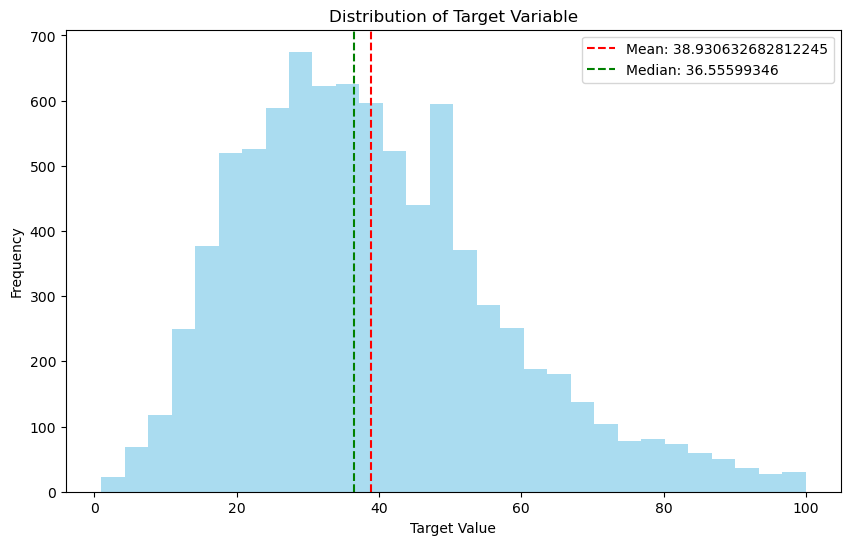

In [222]:
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=30, alpha=0.7, color='skyblue')
plt.axvline(y_train.mean(), color='red', linestyle='--', label=f'Mean: {y_train.mean()}')
plt.axvline(y_train.median(), color='green', linestyle='--', label=f'Median: {y_train.median()}')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.legend()
plt.show()

Numeric stats:
                     mean  std   min   max
num__temp_C          0.0  1.0 -3.00  2.57
num__slp_hPa         0.0  1.0 -2.87  3.03
dt__dt__hour        -0.0  1.0 -1.61  1.66
dt__dt__is_weekend  -0.0  1.0 -0.64  1.57


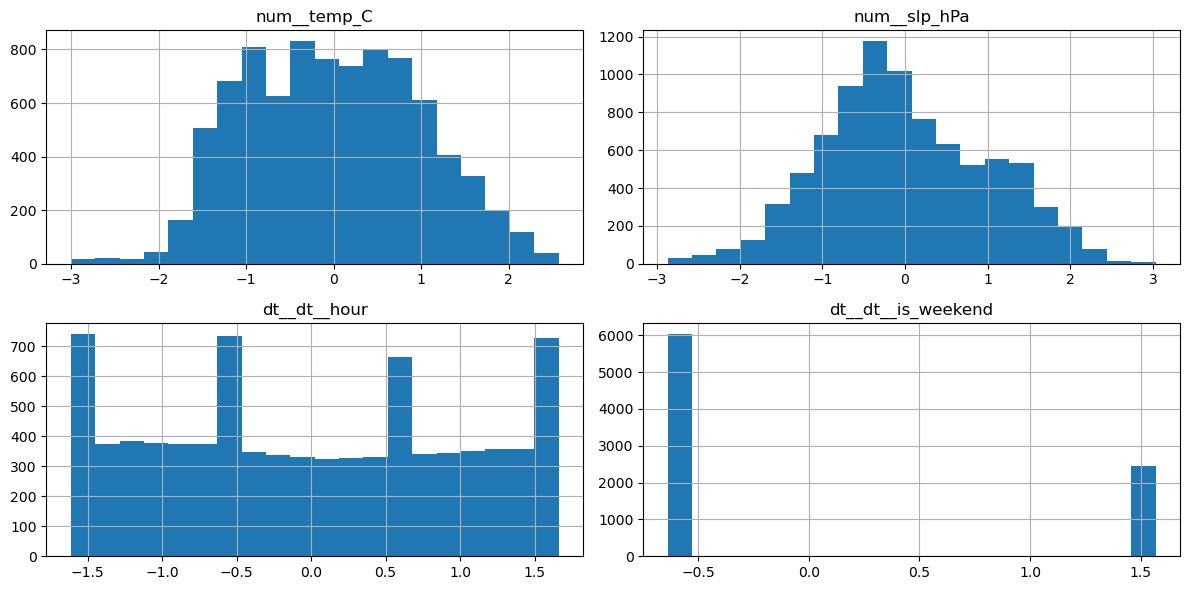

In [223]:
num_cols = X_train.select_dtypes('number').columns
print("Numeric stats:\n", X_train[num_cols].describe().T[['mean','std','min','max']].round(2))
# Plot first 5 histograms*
X_train[num_cols[:5]].hist(bins=20, figsize=(12,6))
plt.tight_layout()
plt.show()

Top correlations:
 dt__dt__hour          0.356
num__temp_C          -0.181
num__slp_hPa          0.177
dt__dt__is_weekend   -0.166
dtype: float64


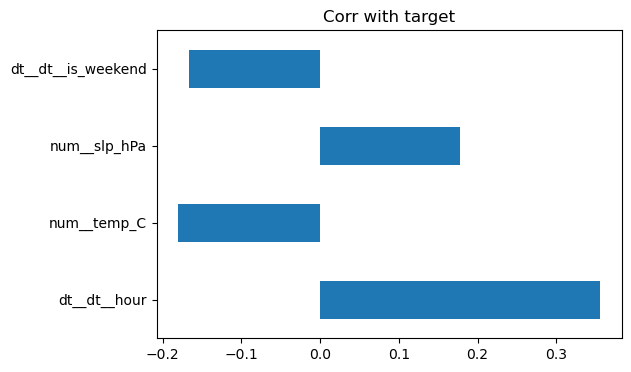

In [224]:
corrs = X_train[num_cols].corrwith(y_train).sort_values(key=abs, ascending=False)
print("Top correlations:\n", corrs.round(3))
corrs.plot.barh(figsize=(6,4)); plt.title("Corr with target"); plt.show()